Project Description: Make the accessibilty map of transportation of service stops within 10, 15, and 25 minutes by walk from an interested point in Wellington. In this case our interested point is at the Messay Uni Gym. Location is (x = -41.302052, y = 174.774323). And will also create another function and apply it in creating an isochrone map from bus routes. 


#### Student: Thatsanee and Pawanee.


Firstly Import our library to be used for this project

In [1]:
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
import fiona 
import pandas as pd

### This project has four mains parts:
1. To make isochrone map (equal time travel) from the interested point. This is to see how far we can reach ithin the assigned times, and speed.
2. To use Isochrone polygons to identify how many transportation service stops we can reach within those given times from all directions.
3. I Will also create another function that generate walking isochrone from the start location and travel time. 
4. I will also create a route isochrone map from bus route points by using demo data. 

#### 1. First Part

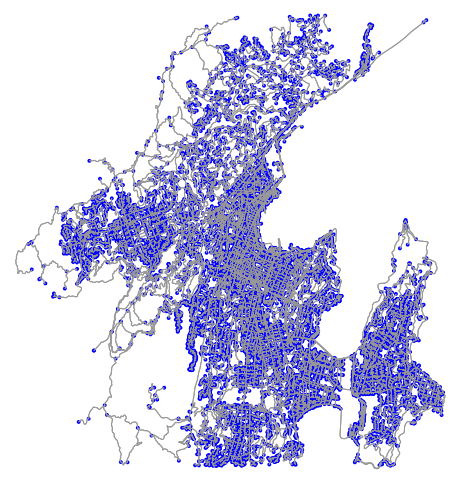

In [2]:
# Let's load data in wellington using osmnx library
place = "Wellington, New Zealand"
# set Transportation type / This is to get all walkable roads/paths from the network.
mode = "walk"
# determines time to walk and its speed
trip_times = [10, 15, 25] #in minutes
travel_speed = 5  #walking speed in km/hour this is special for someone who walk fast
# 3. Create network graph from adress / I just hide the nodes
G = ox.graph_from_address(place, distance=6000, simplify=True, network_type=mode)
# 4. Plot the network graph
fig, ax = ox.plot_graph(G, fig_height=12, fig_width=8, node_color='b')
# The good thing of this road nework data is that it has nodges.


In [3]:
# Create_nodes to Geodataframe and get the nearest nodge from interested point.

gdf_nodes = ox.graph_to_gdfs(G, edges=False)

# here is our interested point # It is near the massey uni gym.
x = -41.302052
y = 174.774323

point_of_interest = ox.get_nearest_node(G, (x, y))




In [4]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute because we will use minutes because the trip times we set are in minutes.
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [5]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=3, cmap='RdPu', start=0.3, return_hex=True)


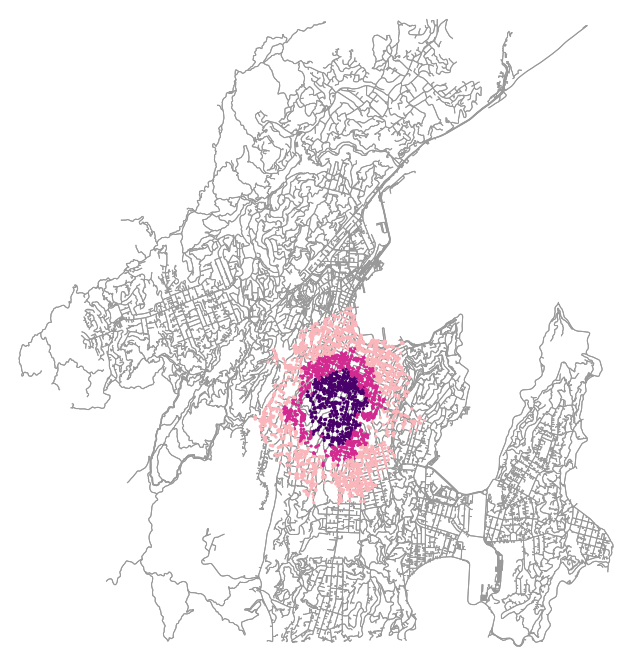

In [6]:
# color the nodes in the reachable area and plot the net work. 
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=12, node_color=nc, node_size=ns, node_alpha=1, node_zorder=2)

In [7]:
# let's make the isochrone polygons by using convex hull polygon method.
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

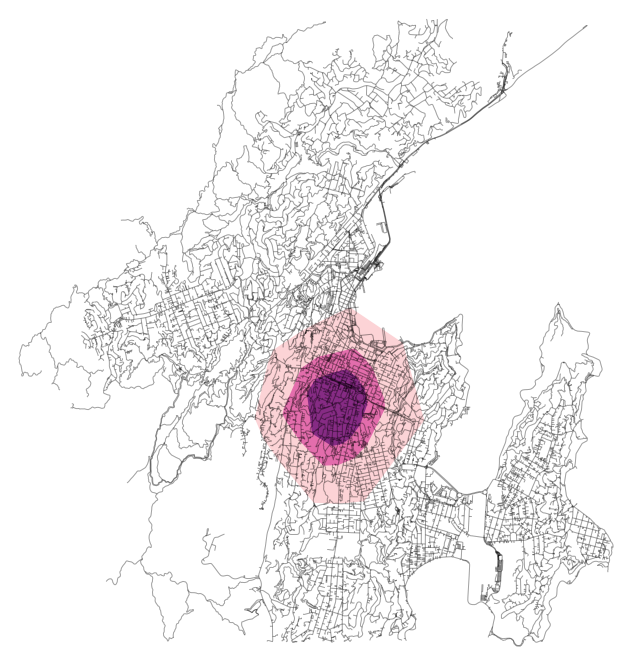

In [8]:
# this is to plot the network and then add isochrones as colored descartes polygon patches

fig, ax = ox.plot_graph(G, fig_height=12, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [9]:
# First Check this polygons.
isochrone_polys

In [10]:
# convert this one to GeoDataframe
gdf = geopandas.GeoDataFrame(pd.DataFrame(isochrone_polys, columns=["geometry"]), geometry='geometry', crs="EPSG:4326")


In [11]:
# Now let's export the isochrone polygon to the shapefile. In case I want to use in other purposes.
gdf.to_file("isochrone.shp") # export into Shapefile # just to check!

#### 2. Second Part

In [12]:
# open the saved polygons, transportation stations, and wellington polygon.
well = geopandas.read_file('wgtn_pop_2013.shp')
well_transportation = geopandas.read_file('Wellington_transportation_Service_stops.shp')
iso_poly = geopandas.read_file("isochrone.shp")

In [13]:
iso_poly = iso_poly.to_crs(well_transportation.crs) #  set projection iso_poly with well area polygon. Because I want to map them together.

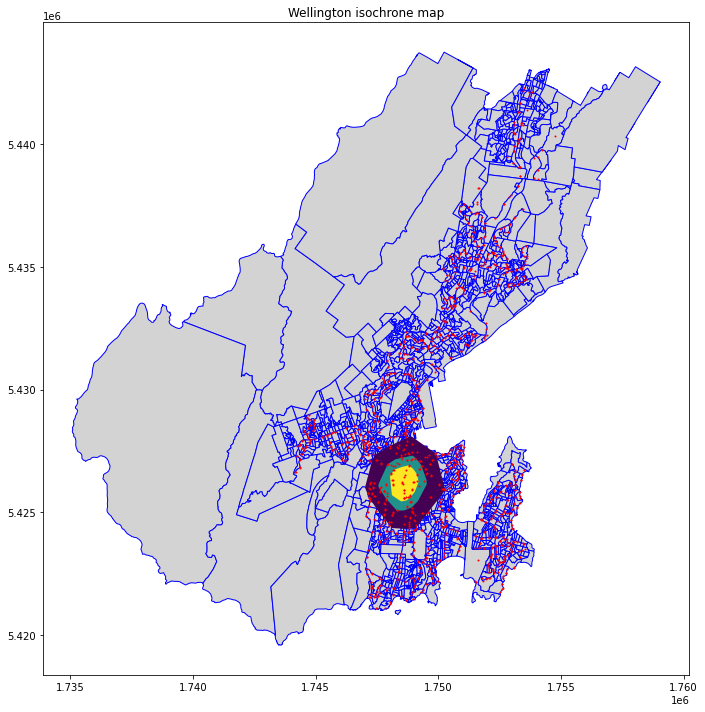

In [14]:
# Map it to get some general idea

fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Wellington isochrone map")

# Plot 
well.plot(ax=ax, facecolor="lightgrey", edgecolor="blue")
iso_poly.plot(ax=ax, column='FID')
well_transportation.plot(ax=ax, color='r', markersize=1)

In [15]:
# now seperate each polygon based on its time spending for walking

walk_25 = iso_poly[iso_poly["FID"] == 0]
walk_15 = iso_poly[iso_poly["FID"] == 1]
walk_10 = iso_poly[iso_poly["FID"] == 2]



In [16]:
# It's time to clip transportation station (points) in Wellington
# to show how many stations we can reach by walkig from the interested point within 10, 15 and 25 minutes.
transportation_25 = geopandas.clip(well_transportation, walk_25)
transportation_15 = geopandas.clip(well_transportation, walk_15)
transportation_10 = geopandas.clip(well_transportation, walk_10)

In [17]:
transportation_10.to_csv('10_minutes.csv', index=False) # just to check

In [18]:
print(transportation_25.shape) # to show how many transportation service stop in the area of 25 mminutes walk. (176)
print(transportation_15.shape) # to show how many transportation service stop in the area of 15 mminutes walk. (69)
print(transportation_10.shape) # to show how many transportation service stop in the area of 10 mminutes walk. (29)

(176, 9)
(69, 9)
(29, 9)


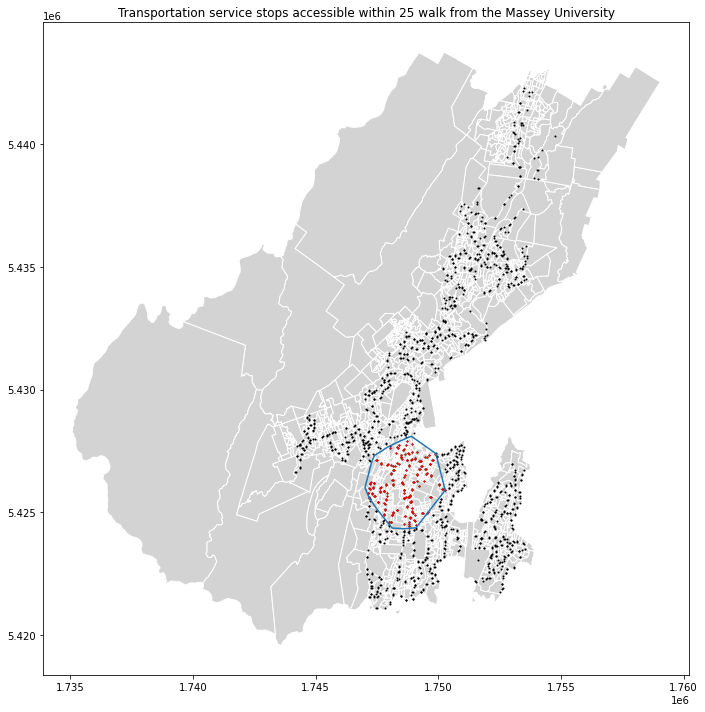

In [19]:
# Now it's time to map!


fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Transportation service stops accessible within 25 walk from the Massey University")

# Plot 
well.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
walk_25.boundary.plot(ax=ax)
well_transportation.plot(ax=ax, color='k', markersize=1)
transportation_25.plot(ax=ax, color='r', markersize=1)



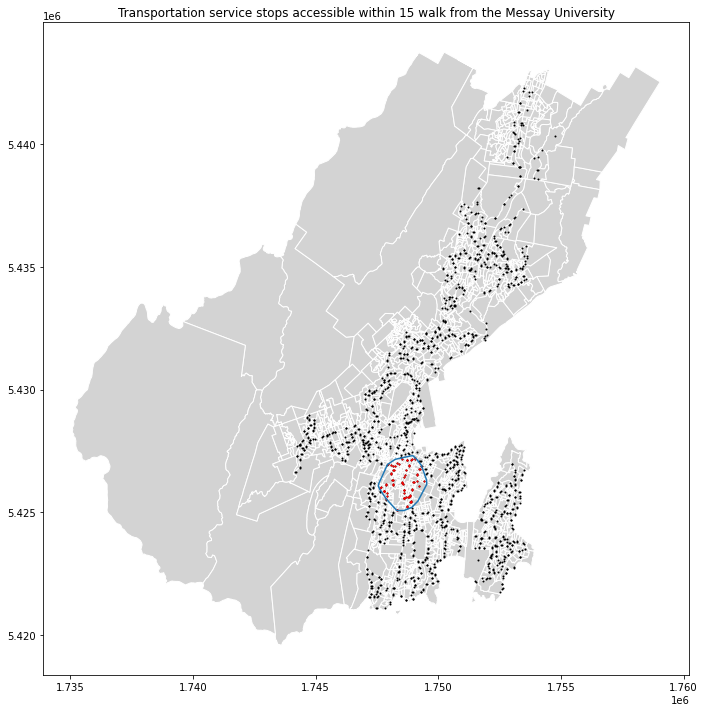

In [20]:
# Map it to get some general idea. Walk time = 15 minutes.

fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Transportation service stops accessible within 15 walk from the Messay University")

# Plot 
well.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
walk_15.boundary.plot(ax=ax)
well_transportation.plot(ax=ax, color='k', markersize=1)
transportation_15.plot(ax=ax, color='r', markersize=1)


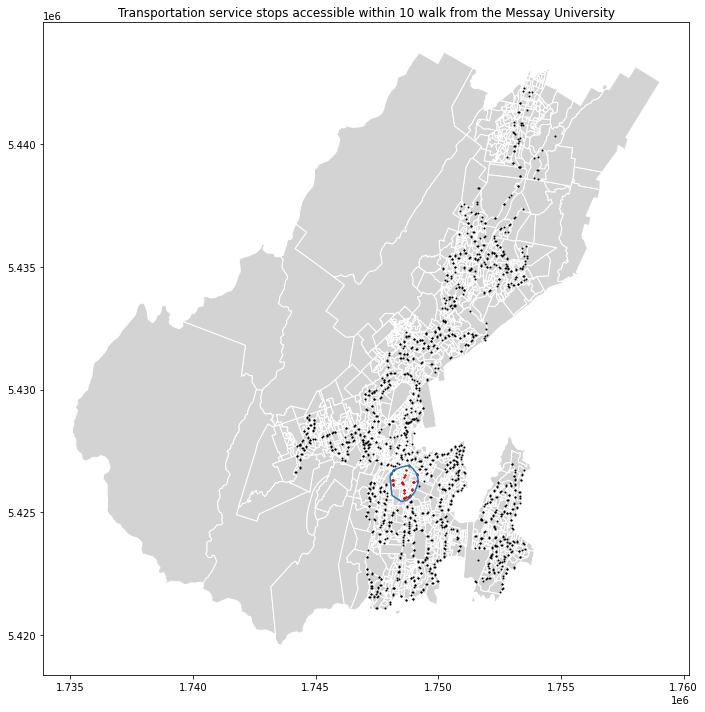

In [21]:
# Map it to get some general idea. Walk time = 10 minutes.

fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Transportation service stops accessible within 10 walk from the Messay University")

# Plot 
well.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
walk_10.boundary.plot(ax=ax)
well_transportation.plot(ax=ax, color='k', markersize=1)
transportation_10.plot(ax=ax, color='r', markersize=1)

#### 3. Third Part
This part we will try to make functions for this processes and we will try to make another function to do different type of isochrones. 

In [22]:
# Write a function to get isochrone polygons of walking from the interested point. This function assumes that the speed of walking is 5 km / hours. 
def get_isochrone(lat_location, long_location, walking_time=0): # This function is to get one ispchrone polygon from the time walking from any location near walkable networks. 
    
    G = ox.graph_from_point((lat_location, long_location), distance=10000, simplify=True, network_type="walk") # this to get graph 10 km from the started point.
    point_of_interest = ox.get_nearest_node(G, (lat_location, long_location)) # to get the nearest nodge from the input lat and long coordinates. 
    gdf_nodes = ox.graph_to_gdfs(G, edges=False) # convert Graph to Geodataframes.
    
    # This is to add the data into edges of the networks.
    # we assume that the speed of the walking is 5 km per hour which equal to 83.33 m per minutes
    # add an edge attribute for time in minutes required to traverse each edge.
    
    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length'] / 83.33         
   
    # create Geoseries from the furthest nodges of the subgraph. 
    
    subgraph = nx.ego_graph(G, point_of_interest, radius=walking_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    return bounding_poly # this one will return isochrone geometry in a given location and time. 
        

In [23]:
# now let's try to use this function if it works or not. I will use the location near victoria university. Here is its lat and long coordinate (-41.290039, 174.769246)
# And another location in Crofton downs which is in the north Wellington (-41.254638, 174.765831). 
ichrone1 = get_isochrone(-41.290039, 174.769246, 25) # let's say I will walk only 25 minutes
ichrone2 = get_isochrone(-41.254638, 174.765831, 20) # let's say I will walk only 20 minutes 

In [24]:
# Now try to map both of them, but I will firstly convert it to Geodataframe first
    
# for the first isochrone
iso = geopandas.GeoDataFrame(pd.DataFrame([ichrone1], columns=["geometry"]), geometry='geometry', crs="EPSG:4326") 
# for the second isochrone
iso2 = geopandas.GeoDataFrame(pd.DataFrame([ichrone2], columns=["geometry"]), geometry='geometry', crs="EPSG:4326") 


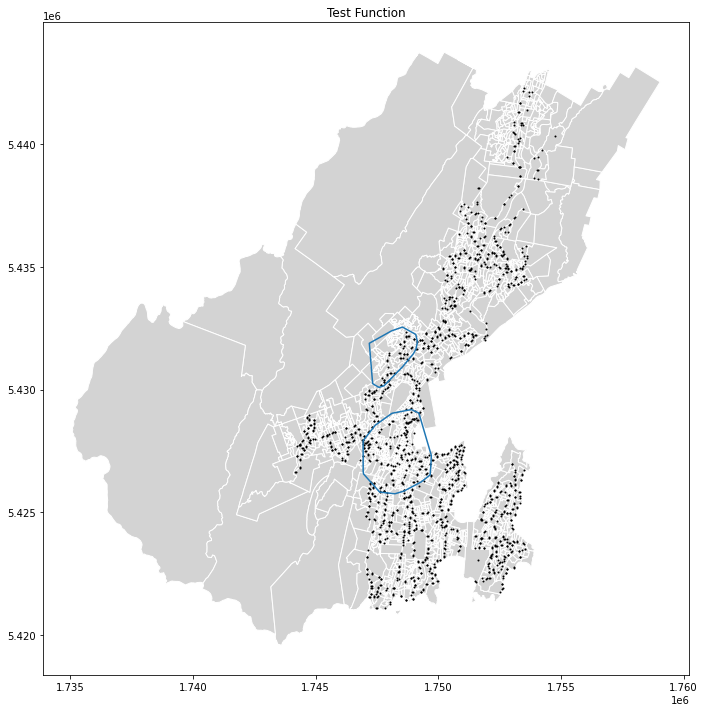

In [38]:
# Let's plot it
iso = iso.to_crs(well_transportation.crs)
iso2 = iso2.to_crs(well_transportation.crs)
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Test Function")
well.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
iso.boundary.plot(ax=ax)
iso2.boundary.plot(ax=ax)
well_transportation.plot(ax=ax, color='k', markersize=1)

#### 4. Fourth Part
This part aims at making isochrone map from bus route (points). 

In [26]:
# now let's load the sample data. This data is the bus stop points in wellington. However, due to it takes so much time in running too many points. I will just select only 20 bus stops to test if the codes work. 
df = pd.read_csv('Bus_Sample.csv', delimiter=',')
 
# Create a list of tuples for Dataframe rows using list comprehension
bus_route = [tuple(row) for row in df.values]
 
# Print list of bus stops and time travel from the first bus stop.
print(bus_route)


[(174.77691399999998, -41.310867, 0.0), (174.771924, -41.320671000000004, 3.0), (174.78675800000002, -41.312606, 2.0), (174.793459, -41.3172, 4.0), (174.765167, -41.304922999999995, 4.0), (174.765041, -41.316794, 4.0), (174.78028700000002, -41.323639, 7.0), (174.775073, -41.323693, 7.0), (174.75967, -41.291753, 8.0), (174.77439099999998, -41.327929, 9.0), (174.773504, -41.334878, 14.0), (174.795567, -41.324538000000004, 12.0), (174.780298, -41.315366, 2.0), (174.780581, -41.319251, 3.0), (174.77889299999998, -41.304531, 3.0), (174.769704, -41.296026, 5.0), (174.781304, -41.298899, 4.0), (174.772352, -41.287969, 6.0), (174.775039, -41.281352000000005, 14.0), (174.752477, -41.282539, 15.0)]


In [27]:
# note that, in this case, the state point is this bus stop (74.77691399999998, -41.310867). I assume the start location time is 0.

In [28]:
# Now I will create an empty list of geometry created from each bus stop location. 
isochrone_list_polygon = []
# isochrone_list_point = [] 

In [29]:
for stop in bus_route:
    x = stop[1]
    y = stop[0]
    t = 15.0-float(stop[2])
    if t > 0.0:
        point_iso = get_isochrone(x, y, t)
        isochrone_list_polygon.append(point_iso)
    if t < 0.0 :
        pass # do nothing if t < 0 and = 0 . # in case there is a negative value. I dont need to do any thing with negative time
    else:
        pass 
        # if t = 0 the function get_isochrone will generate only a point of that bus stop, not polygon. I will do nothing if the time equal to 0 as well.
        # Possibly add these point into different list and make buffer out of them. Maybe 1 m just to show the location in polygons that you can arrive.  
        # by using this code "point = [Point(y, x)]" and ad to different list which is the list of point # isochrone_list_point.append(point). But in this case I will only focus only if the time is higher than 0. 

In [30]:
# now change the list of geometry into Geodataframe.
gdf_bus_route = geopandas.GeoDataFrame(pd.DataFrame(isochrone_list_polygon, columns=["geometry"]), geometry='geometry', crs="EPSG:4326")

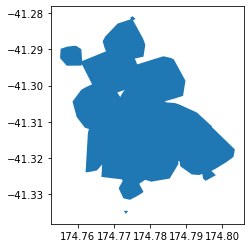

In [31]:
# Now just check the result.
gdf_bus_route.plot()

In [32]:
# now let's merge these polygons together. for adjency polygons they will become the same polygon.
iso_busroute = geopandas.GeoDataFrame(pd.DataFrame(gdf_bus_route.unary_union, columns=["geometry"]), geometry='geometry', crs="EPSG:4326")

In [33]:
# export to shapefile. for checking.
iso_busroute.to_file("test_busroute_2.shp")

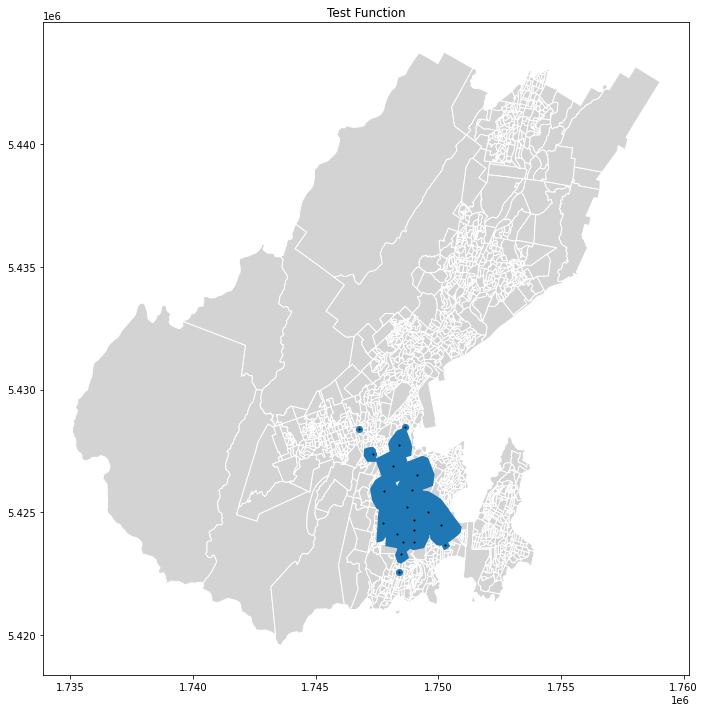

In [34]:
# now let's map them!
# firstly load the bus route and sample data.
samples = geopandas.read_file('Bus_sample.shp')
route = geopandas.read_file('routes.shp')
# Let's change projection
samples = samples.to_crs(well.crs)
route = samples.to_crs(well.crs)
iso_busroute = iso_busroute.to_crs(well.crs)
# map!
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_facecolor('white')
ax.set_title("Test Function")
well.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
iso_busroute.plot(ax=ax)
route.plot(ax=ax)
samples.plot(ax=ax, color='k', markersize=1)

Thank You!